## Measuring and Analyzing the Thermal Performance Properties of Three Fabrics.
Fabric A, Fabric A with a thermal liner material positioned beneath it, and Fabric B were each cut to the exact dimension of the hot plate. The heat flux and energy transfer properties determined in this program were calculated from measurements of thermal transport made with a guarded hotplate system from Measurement Technology Northwest Inc. Samples were tested using the same hot plate temperature of 35°C found in the ASTM F 1868.


Each sample was allowed to reach a steady state with the hot plate prior to the dry ice block being placed on top. The dry ice block was placed on top of the fabric for 5 seconds before being taken off and returned to a designated cooler. 

Experiments were terminated when the fabric and hot plate returned to steady state or close to. Another dry ice block was also in the cooler helping to minimize the sublimation of the block used in the experiments. The same side of the dry ice block was used for every test. A stopwatch was used to measure a duration of 5 seconds, human variability with picking up dry ice with low dexterity gloves exacerbates this variance.

 
![Experiment Setup](Dry_Ice_block.jpg)


In [38]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math
from scipy.integrate import trapz
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from statsmodels.stats.libqsturng import psturng
from glob import glob
import os 


#### Import CSV files of fabric swatches from heated hot plate machine

In [39]:
search_terms = ['D200', 'DT', 'PVC']  # search terms in csv. file that designate the fabric type tested
fabrics = ['A', 'A + Thermal Liner', 'B']  # names of the fabrics that are used as keys 

fabric_dict = {} #  dictionary with keys as names, values are list of csv files
total_replicates = 0

for term, fabric_ID in zip(search_terms, fabrics):  
    fabric_dict[fabric_ID] = glob(term + '*')
    total_replicates += len(fabric_dict[fabric_ID] )

    
mean_and_std_results = {
                        'Mean Maximum Plate Heat Flux [W/m^2]': [],
                        'Standard Deviation Plate Heat Flux [W/m^2]': [],
                        'Coefficient of Variation of Plate Heat Flux [%]': [],
                        'Mean Total Plate Energy [J]': [],
                        'Standard Deviation Plate Energy [J]': [],
                        'Coefficient of Variation of Plate Energy [%]': [],
                        'Mean Average Plate Heat Flux [W/m^2]': [],
                        'Replicates (n)': [],
                        }

raw_results ={
            'Maximum Plate Heat Flux [W/m^2]': [],
            'Total Plate Energy [J]': [],
            'Average Plate Heat Flux [W/m^2]': [],
            }


#####  Define Matplotlib Plotting Settings

In [40]:
font = {'size'   : 15}

matplotlib.pyplot.rc('font', **font)

### Function to plot, calculate max, mean, and standard deviation of heat flux from replicates   

In [41]:
def plot_and_calc_max_flux(file_list: 'List of .csv file replicates', fabric_name: 'title of fabric batch') -> 'mean and std of plate flux':
    max_flux = np.zeros(len(file_list))
  
    fig, ax = plt.subplots(figsize=(14,7))
    plt.xlabel('Time (seconds)', labelpad=20)
    plt.ylabel(r'Heat Flux $\frac{W}{m^2}$')

    for i, rep in enumerate(file_list):
        df = pd.read_csv(rep, skiprows = 16)  # data starts at line 17
        reduced_df = df.loc[1:,['Time' ,'Heat Flux Measured']] # further reduce dataframe to include only the columns of interest 
        reduced_df = reduced_df.astype('float64')  # cast data from object to float64
        max_flux[i] = reduced_df['Heat Flux Measured'].max()  # return max value from series and append to my list

        label = f'Replicate {i+1}: ' # generate labels
        plt.plot(reduced_df['Time'], reduced_df['Heat Flux Measured'], label=f'{label + rep}') # plot each replicate stacked ontop

    plt.legend()
#     plt.xlim((150, 450))  # adjust limits of x-axis
    plt.title(f'Fabric {fabric_name} : Heat Flux Measured By Test Plate')

    fabric_mean=np.mean(max_flux)
    fabric_std=np.std(max_flux)
    fabric_cv = (fabric_std / fabric_mean) * 100
    
    package = [fabric_mean, fabric_std, fabric_cv]
    
    
#     for k, item in enumerate(package):
#         package[k] = round(item, 4)
    
    return package, list(max_flux)


### Calculation of Thermal Performance Metrics 

### Normalize Energy (E') 
The total energy per unit area $(E')$  provided by the hot plate due to the dry ice response was numerically calculated in Python using the following equation:	

$$
E' ,
\begin{equation}
 \left [  \frac{ J } {m^2 }  \right]
\end{equation}
$$


$$ E' = \int_{t_i}^{t_f} \phi_{hot plate}dt - \frac{1}{2} [\phi_{hot plate}(t_i) + \phi_{hot plate}(t_f)]\Delta t $$

where $t_i$,$t_f$ denote the initial and final time respectively from the step response from the dry ice being placed on top of the fabric and the time when steady state returns. $\phi_{hot plate} (t)$ refers to the heat flux at steady state times $t_i$ and $t_f$ bounding the step-response. $\Delta t$ is simply the difference between the two values. The term after the integrand, in the equation above, simply subtracts the average energy per unit area $(E')$ required to maintain steady state. Thus, the value $(E')$ is the additional energy per unit area required by the plate when responding to the dry ice step-response.

### Total Energy (E): 
The total energy $(E)$ measured by the heated hot plate can be found by simply multiplying $E'$ by the area of the sample.

$$ E= E' * A_{frabic}$$

$$ A_{frabic}$$ denotes the area of the sample fabric in squared meters. Since all the fabric were cut using a template to 12 X 12 inches, or 1 square foot, $A_{frabic}=0.0929 m^2$

### Mean Flux: $$ \bar\phi_{hot plate} = \frac{E}{\Delta t} $$

The average heat flux $(\bar\phi_{hot plate})$ measured by the hot from the moment the dry ice was placed on the fabric back to steady state. 

In [42]:
def calc_mean_energy(file_list: 'List of .csv file replicates', \
                     fabric_name: 'title of fabric batch',steady_state_threshold=5,\
                     threshold_delta=100) -> 'mean and std energy measure by plate':
    fabric_area = 0.0929 
    # steady_state_theshold refers to the number of data collection values \
    # to revert before experiment begins and large spike begins denoting step change
    
    # threshold_delta is the threshold derivative value of heat flux signaling step change and experiment beings
    
    true_energy_array = []
    mean_flux_array = []
    
#     fig, ax = plt.subplots(figsize=(12,7))
    
    for k, rep in enumerate(file_list):
        df = pd.read_csv(rep, skiprows = 16)
        reduced_df = df.loc[1:,['Time' ,'Heat Flux Measured']] # further reduce dataframe to include only the columns of interest 
        reduced_df = reduced_df.astype('float64')  # cast data from object ot float64
        reduced_df = reduced_df.dropna(how='all')  # remove NaN if all rows have NaN


        dh = np.diff(reduced_df['Heat Flux Measured']) / np.diff(reduced_df['Time'])  # numerical Derivative of flux and time
        dh_and_time = np.zeros([len(dh), 2])  # intialie aray

        dh_and_time[:,0] = reduced_df.iloc[1:]['Time'].values  # populate array with time
        dh_and_time[:, 1] = dh  # populate array with derivative

        dh_and_time = dh_and_time[dh_and_time[:,1] > 0]  # remove anywhere derivative is 0 to remove step-signal noise


        thershold_time = 0  # time where step change occured
        threshold_index = 0  # index in array where step change occured

        for i, derivative in enumerate(dh_and_time[:,1]):  # search where the first occurance of large step change in heat flux
            if derivative > threshold_delta:
                threshold_time = dh_and_time[i - steady_state_threshold,0] # use threshold to go just before event
                threshold_index = i - steady_state_threshold
                break

        # search where the first occurance of large step change in heat flux in reverse to denote return to Steady State
        base_line_flux = reduced_df[reduced_df['Time'] >= threshold_time].values[0][1]  # base line value before step change
        reverse_flux_with_time  = np.flip(reduced_df['Heat Flux Measured'].values, 0)  # reverse flux sequence
        array_length = len(reduced_df['Heat Flux Measured'].values)


        temp = reduced_df.values # turn into array

        for n in range(26):

            threshold_time_stop, d = temp[np.abs(temp[:,1] - base_line_flux) <= n+1 ][-1]  # Find where the abs diff between baseline and stoping is less than n 
            if d is not None and (threshold_time_stop-threshold_time) > 100:
                break
            elif n == 25:
                threshold_time_stop, d = temp[-1,:]

        time_interval = threshold_time_stop -  threshold_time
        
#         print('\nStart Event:', threshold_time,'\nEnd Event:', threshold_time_stop,)

        step_change_df = reduced_df[(reduced_df['Time'] >= threshold_time) & (reduced_df['Time'] <= threshold_time_stop)] # focus only on the data where experiment occurs
        total_energy = trapz(step_change_df['Heat Flux Measured'],step_change_df['Time'])  # total energy + baseline energy
        average_baseline = (step_change_df['Heat Flux Measured'].values[0] + step_change_df['Heat Flux Measured'].values[-1]) * 0.5  # ave base line flux
        baseline_total_energy = average_baseline*time_interval # calculate baseline energy 
        true_energy = (total_energy - baseline_total_energy)  # remove baseline enegy 
        
        true_energy_array.append(true_energy * fabric_area) # true energy of plate
        mean_flux_array.append(true_energy / time_interval) # mean flux during experiment
        
        
    mean_total_plate_energy = np.mean(np.asarray(true_energy_array))
    mean_ave_flux = np.mean(np.asarray(mean_flux_array))
    std_plate_energy = (np.std(np.asarray(true_energy_array)))
    cv_plate_energy = (std_plate_energy / mean_total_plate_energy) * 100
    
    package = [mean_total_plate_energy, std_plate_energy, cv_plate_energy, mean_ave_flux, len(file_list)] 
    raw_data = [true_energy_array, mean_flux_array]
    
#     for z, item in enumerate(package):
#         package[z] = round(item, 4)
        
    return package ,raw_data           
        

### Function to Generate Comparison Tests for Key Variables

In [43]:
def comparison_test(df_with_raw_data):
    for column in df_with_raw_data.columns:
        sol = pairwise_tukeyhsd(df_with_raw_data[column], list(df_with_raw_data.index))
        p_values = psturng(np.abs(sol.meandiffs / sol.std_pairs), len(sol.groupsunique), sol.df_total)
        
        print('\n****** PERFORMING COMPARISON TEST ********')
        print(f'Comparing {column} against Each Fabric')
        print ('\n',sol)
        print(f'Respective P-Values: {p_values}')

### Iterate through Fabric dictionary to plot and generate max values
Append mean maximum heat flux and standard deviation of heat flux to results

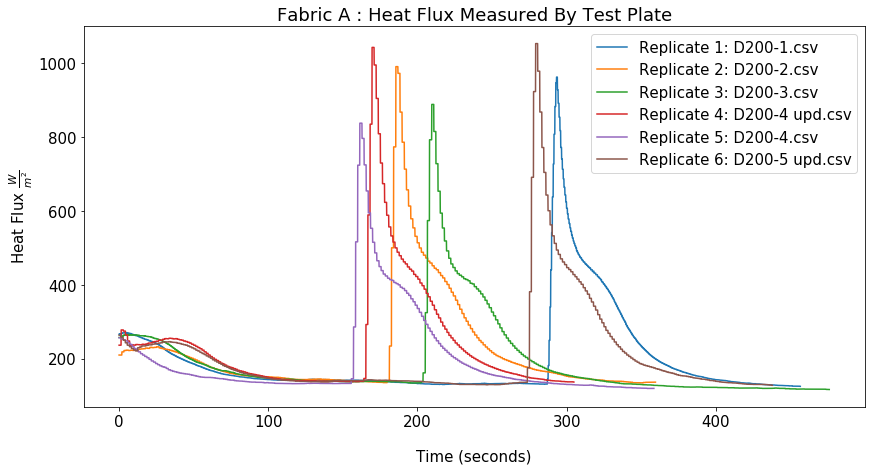

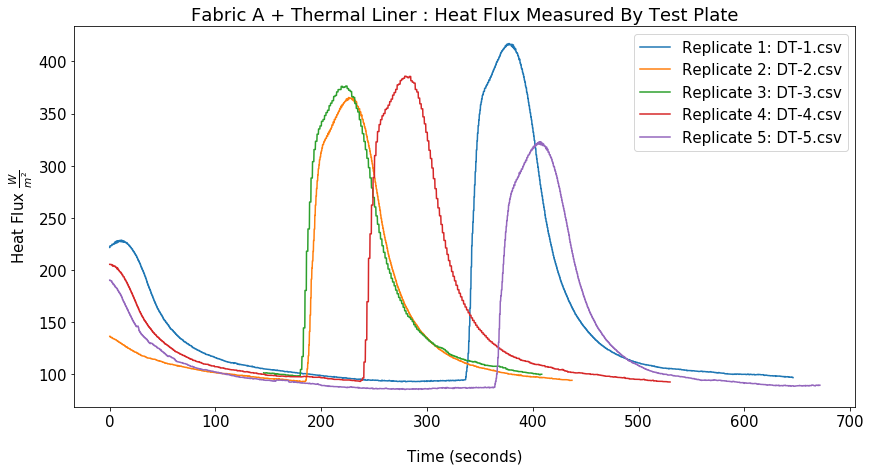

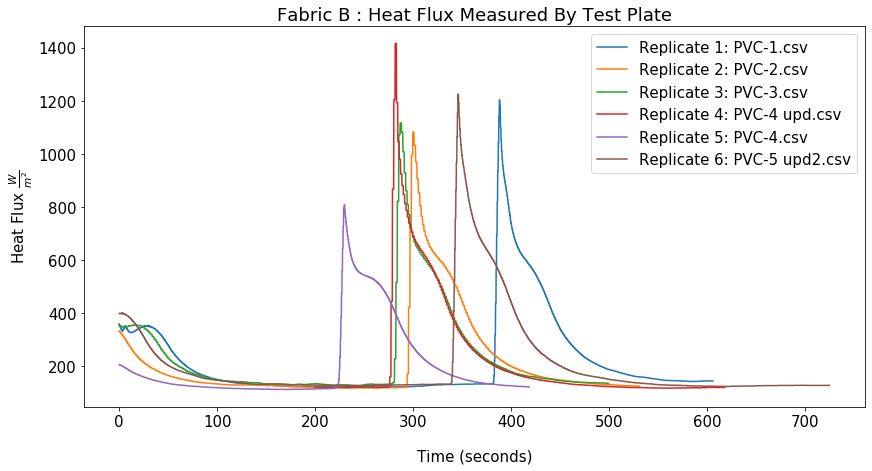

In [44]:
for fabric_key, replicates in fabric_dict.items():
    max_flux_package, maximum_flux = plot_and_calc_max_flux(replicates, fabric_key)
    energy_package, raw_values = calc_mean_energy(replicates, fabric_key)
    
    raw_package =  [maximum_flux] + raw_values
    packed_values = max_flux_package + energy_package
    

    for i, (key, value) in enumerate(raw_results.items()):
        raw_results[key].extend(raw_package[i]) # add multiple items to dictionary values
    
    
    # append returned means, stds, cv, and n to dictionary
    for i, (key, value) in enumerate(mean_and_std_results.items()):
        mean_and_std_results[key].append(packed_values[i])



## Generate CSV for Max Heat Flux and Statistical Summary


In [45]:
results_df = pd.DataFrame(mean_and_std_results, index=fabrics )
column_names = results_df.columns.tolist()
column_names = column_names[0:3] + [column_names[-2]] + column_names[3:6] + [column_names[-1]] # reorder columns

results_df =results_df[column_names]
export_csv = results_df.to_csv('summary.csv', sep='\t', encoding='utf-8')
results_df

,Mean Maximum Plate Heat Flux [W/m^2],Standard Deviation Plate Heat Flux [W/m^2],Coefficient of Variation of Plate Heat Flux [%],Mean Average Plate Heat Flux [W/m^2],Mean Total Plate Energy [J],Standard Deviation Plate Energy [J],Coefficient of Variation of Plate Energy [%],Replicates (n)
A,962.883333,78.102996,8.111367,129.565471,1833.499322,336.508796,18.353364,6
A + Thermal Liner,373.440000,30.582714,8.189459,77.123011,1927.890221,229.102955,11.883610,5
B,1141.366667,183.080517,16.040465,168.664000,3687.716460,375.052782,10.170326,6


### Generate Dataframe for Raw Data to Perform Pairwise Tukey Multiple Comparisons of Means

In [46]:
string_name=[]
for i, row in enumerate(results_df['Replicates (n)']):
    string_name.extend( [(list(results_df.index)[i] + ' ')] * row)  # generate index using replicate numbers for each fabric

raw_df = pd.DataFrame(raw_results, index=string_name)
raw_df_export = raw_df.to_csv('raw.csv', sep='\t', encoding='utf-8')

### Tukey Multiple Comparisons of Means

A Tukey’s statistical test was performed with a significance level of 0.05 in order to compare whether the mean of one performance metric for a piece of fabric was statistically significant from another fabric. The three metrics chosen were maximum plate heat flux ($\phi_{hot plate}^{max}$), average plate heat flux($\bar\phi_{hot plate}$), and total plate energy ($E$)

In [47]:
comparison_test(raw_df)


****** PERFORMING COMPARISON TEST ********
Comparing Maximum Plate Heat Flux [W/m^2] against Each Fabric

               Multiple Comparison of Means - Tukey HSD, FWER=0.05               
      group1             group2        meandiff p-adj   lower     upper   reject
--------------------------------------------------------------------------------
                A  A + Thermal Liner  -589.4433  0.001 -797.899 -380.9877   True
                A                  B   178.4833 0.0813 -20.2713   377.238  False
A + Thermal Liner                  B   767.9267  0.001  559.471  976.3823   True
--------------------------------------------------------------------------------
Respective P-Values: [0.001      0.08131039 0.001     ]

****** PERFORMING COMPARISON TEST ********
Comparing Total Plate Energy [J] against Each Fabric

               Multiple Comparison of Means - Tukey HSD, FWER=0.05               
      group1             group2        meandiff p-adj   lower     upper   reject
--------

## SUMMARY:

##### In summary, the data highly suggests that Fabric A + thermal liner fabric is the most insulative fabric of the three as it statistically had the lowest maximum plate heat flux ($\phi_{hot plate}^{max}$) and the lowest average plate heat flux ($\bar\phi_{hot plate}$). 

##### The Tukey’s comparison test for the Fabric A without the thermal liner and Fabric B suggest that the ranking of the fabric is dependent on the metric used. Hence, one may or not may not be better depending on the thermal performance metric chosen, i.e., maximum plate heat flux ($\bar\phi_{hot plate}$), average plate heat flux ($\phi_{hot plate}^{max}$), and total plate energy ($E$). 